# Setup

In [1]:
import data
import model
import utils
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook
import torchvision.models as models
from sklearn.metrics import accuracy_score

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Loading

In [3]:
dataset = data.dataset(image_root = './DRIMDB')
train_loader, val_loader = data.dataloader(dataset = dataset, batch_size = 16, validation_split = 0.2, shuffle_dataset = True)

# Sample visualization

In [4]:
train_iter = iter(train_loader)

In [5]:
samples, labels = train_iter.next()

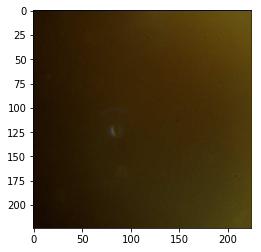

In [6]:
trial_num = np.random.randint(0, 4)
utils.imshow(samples[trial_num])

In [7]:
print(labels[trial_num])

Bad


# Model

In [8]:
# cnn = torchvision.models.alexnet(pretrained = True).to(device)
cnn = model.AlexNet(num_classes = 3).to(device)

In [9]:
# for param in cnn.parameters():
#     param.requires_grad = False
# cnn.classifier[-1] = nn.Linear(in_features = 4096, out_features = 3, bias = True)

In [10]:
cnn.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4

In [11]:
for param in cnn.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([4096, 9216])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([3, 4096])
torch.Size([3])


# Training

In [12]:
loss_fn = nn.CrossEntropyLoss()
optm = optim.SGD(cnn.parameters(), lr = 0.001)
n_epochs = 300

In [ ]:
loss_b = []
acc_b = []
for epoch in tqdm_notebook(range(n_epochs)):

    for data in iter(train_loader):
        
        images, labels = data
        images = images.to(device)
        OH_labels = utils.encode_batch(labels, device)
        pred = cnn.forward(images)
        
        cnn.eval()
        acc = accuracy_score(torch.max(pred, 1)[1].cpu(), torch.max(OH_labels, 1)[1].cpu())
        acc_b.append(acc)
        
        cnn.train()
        loss = loss_fn(pred, torch.max(OH_labels, 1)[1])
        loss_b.append(loss.item())
        optm.zero_grad()
        loss.backward()
        optm.step()
        
        del images, labels, OH_labels, pred
        torch.cuda.empty_cache()
    print("|Epoch: {}/{}| |Loss: {:.4f}| |Train Acc: {:.4f}|".format(epoch, n_epochs, loss.item(), acc))

|Epoch: 0 / 300| |Loss: 1.0620| |Train Acc: 0.5385|
|Epoch: 1 / 300| |Loss: 1.0397| |Train Acc: 0.6154|
|Epoch: 2 / 300| |Loss: 1.0233| |Train Acc: 0.6154|
|Epoch: 3 / 300| |Loss: 1.1216| |Train Acc: 0.3846|
|Epoch: 4 / 300| |Loss: 1.0233| |Train Acc: 0.5385|
|Epoch: 5 / 300| |Loss: 1.0328| |Train Acc: 0.5385|
|Epoch: 6 / 300| |Loss: 1.0633| |Train Acc: 0.4615|
|Epoch: 7 / 300| |Loss: 1.0209| |Train Acc: 0.5385|
|Epoch: 8 / 300| |Loss: 1.0160| |Train Acc: 0.5385|
|Epoch: 9 / 300| |Loss: 0.9663| |Train Acc: 0.6154|
|Epoch: 10 / 300| |Loss: 0.9321| |Train Acc: 0.6154|
|Epoch: 11 / 300| |Loss: 1.1301| |Train Acc: 0.1538|
|Epoch: 12 / 300| |Loss: 0.8958| |Train Acc: 0.7692|
|Epoch: 13 / 300| |Loss: 0.8545| |Train Acc: 0.7692|
|Epoch: 14 / 300| |Loss: 0.9065| |Train Acc: 0.6923|
|Epoch: 15 / 300| |Loss: 0.9655| |Train Acc: 0.6154|
|Epoch: 16 / 300| |Loss: 0.9248| |Train Acc: 0.6154|
|Epoch: 17 / 300| |Loss: 1.0604| |Train Acc: 0.4615|
|Epoch: 18 / 300| |Loss: 0.9087| |Train Acc: 0.5385|
|Ep

|Epoch: 153 / 300| |Loss: 0.8284| |Train Acc: 0.5385|
|Epoch: 154 / 300| |Loss: 1.0615| |Train Acc: 0.2308|
|Epoch: 155 / 300| |Loss: 0.5929| |Train Acc: 0.7692|
|Epoch: 156 / 300| |Loss: 0.7177| |Train Acc: 0.6923|
|Epoch: 157 / 300| |Loss: 0.6485| |Train Acc: 0.6154|
|Epoch: 158 / 300| |Loss: 0.4975| |Train Acc: 0.6923|
|Epoch: 159 / 300| |Loss: 0.3959| |Train Acc: 0.8462|
|Epoch: 160 / 300| |Loss: 0.6857| |Train Acc: 0.6923|
|Epoch: 161 / 300| |Loss: 0.6218| |Train Acc: 0.7692|
|Epoch: 162 / 300| |Loss: 0.6894| |Train Acc: 0.6923|
|Epoch: 163 / 300| |Loss: 0.9915| |Train Acc: 0.5385|
|Epoch: 164 / 300| |Loss: 0.7339| |Train Acc: 0.6923|
|Epoch: 165 / 300| |Loss: 0.8294| |Train Acc: 0.4615|
|Epoch: 166 / 300| |Loss: 0.5807| |Train Acc: 0.7692|
|Epoch: 167 / 300| |Loss: 0.6695| |Train Acc: 0.6154|
|Epoch: 168 / 300| |Loss: 0.5083| |Train Acc: 0.7692|
|Epoch: 169 / 300| |Loss: 0.6364| |Train Acc: 0.6923|
|Epoch: 170 / 300| |Loss: 0.8539| |Train Acc: 0.4615|
|Epoch: 171 / 300| |Loss: 0.

In [ ]:
utils.visualize_results(loss_b, acc_b)

In [ ]:
# def evaluate(data_loader):
#     total, correct = 0, 0
#     for data in data_loader:
#         inputs, labels = data
#         OH_labels = utils.encode_batch(labels, device)
#         inputs = inputs.to(device)
#         outputs = cnn.forward(inputs)
#         pred = torch.max(outputs, 1)[1]
#         total += len(labels)
#         correct += (pred == torch.max(OH_labels, 1)[1]).sum().item()

#     print(100 * correct / total)

In [ ]:
# torch.save(cnn.state_dict(), 'checkpoint.pth')
# model.load_state_dict(torch.load(PATH))

In [ ]:
utils.evaluate(val_loader)